In [1]:
import os
import sys
os.environ["THEANO_FLAGS"] = "device=cpu"
sys.path.append(os.getcwd()+"/..")
import lasagne
import theano.tensor as T
import theano
from tasks import check
from scripts import manifold

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
v = check(what="notebook", 
          #filename="..//model.pkl", 
          filename="../out/model.pkl",
          dataset='flaticon',
          force_w=32,
          force_h=32)
          #dataset="fonts",
          #force_w=28,
          #force_h=28)

Loading data...


INFO:tasks:Loading data...
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/PIL/Image.py:870: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


(128, 1024)
Loading the model...


INFO:tasks:Loading the model...


17
(None, 1, 32, 32)
Compiling the model...


INFO:tasks:Compiling the model...
/home/mcherti/work/code/external/Lasagne/lasagne/layers/helper.py:212: UserWarning: get_output() was called with unused kwargs:
	determnistic (perhaps you meant deterministic)
  % "\n\t".join(suggestions))


{'seed': 2}


In [3]:
capsule, data, layers, w, h, c = v
print(w, h, c)
print(layers.keys())

(32, 32, 1)
['input', 'conv1', 'conv2', 'conv3', 'conv4', 'unconv', 'output']


In [4]:
print(layers['input'].shape)

(None, 1, 32, 32)


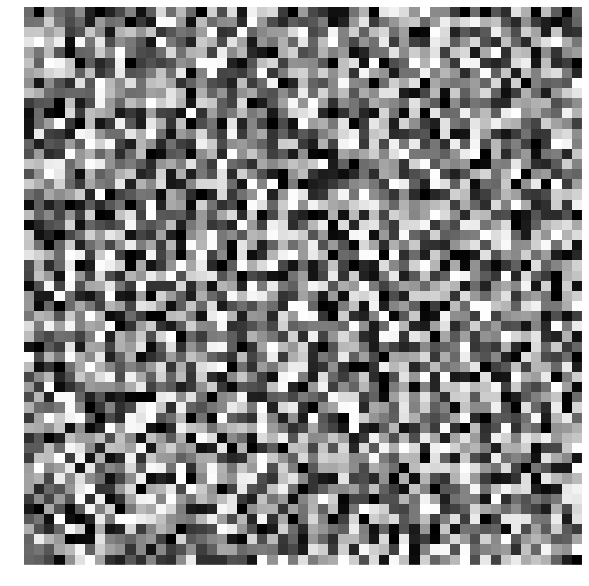

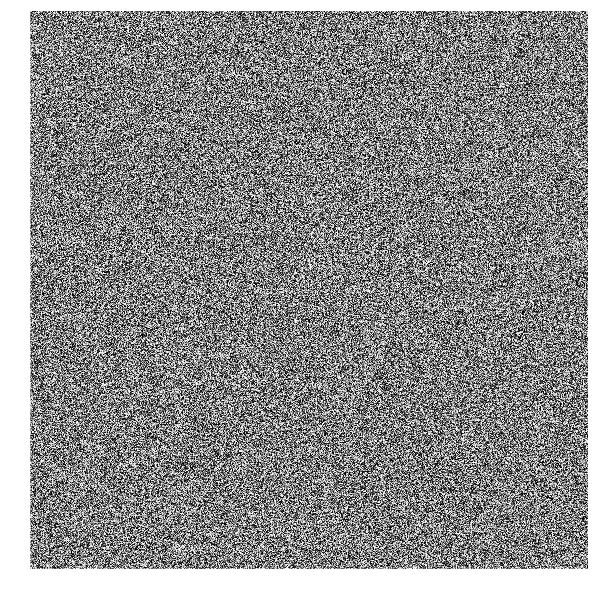

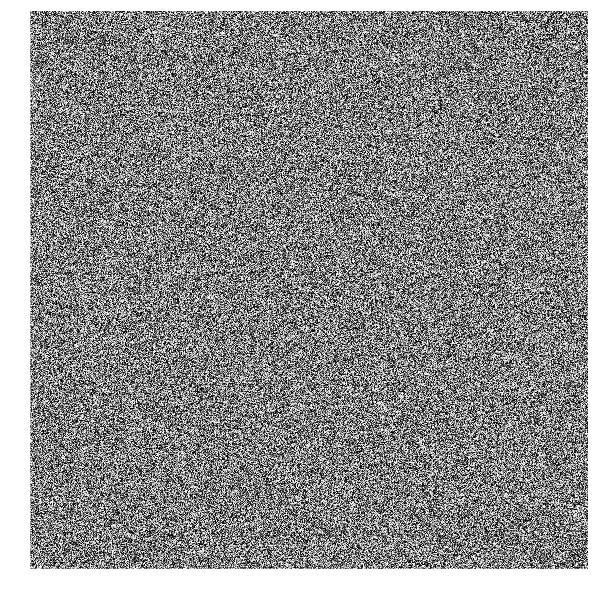

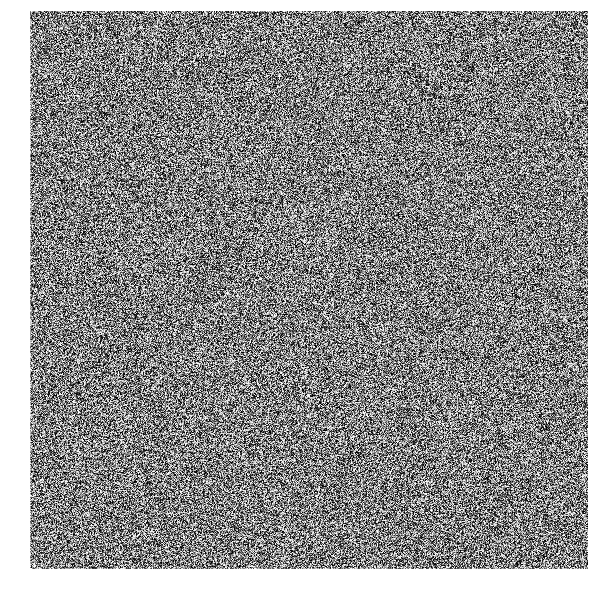

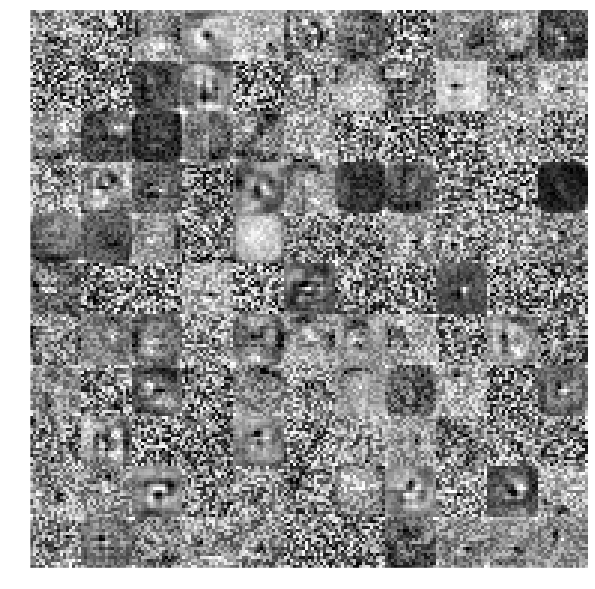

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from lasagnekit.misc.plot_weights import tile_raster_images
import numpy as np
for name, layer in layers.items():
    #print(name, layer.output_shape)
    #if hasattr(layer, "W"):
    #    print(layer.W.get_value().shape)
    if hasattr(layer, "W"):
        W = layer.W.get_value()
        if len(W.shape)==2:
            nbpixels = c*w*h
            if W.shape[0] == nbpixels:
                W = W.T
            a, b = w, h
        else:
            W = W.reshape((W.shape[0]*W.shape[1], W.shape[2], W.shape[3]))
            a, b = W.shape[1:]
        fig = plt.figure(figsize=(10, 10))
        s = int(np.sqrt(W.shape[0]))
        plt.axis('off')
        img=tile_raster_images(W, (a, b), (s, s))
        plt.imshow(img, cmap="gray", interpolation='none')
        plt.show()

In [6]:
hid_nonlinearity = 'sigmoid'
out_nonlinearity = 'sigmoid'

def get_deriv(func, x, direct=False):
    if func == 'sigmoid':
        if direct:
            x_ = x
        else:
            x_ = T.nnet.sigmoid(x)
        return x_ * (1 - x_)
    elif func == 'tanh':
        if direct:
            x_  = x
        else:
            x_ = T.tanh(x)
        return 1 - x_ **2

In [7]:
X = T.tensor4()

Xrec = lasagne.layers.get_output(layers['output'], X)
Xrec = Xrec.reshape((Xrec.shape[0], -1))

xflat = X.reshape((X.shape[0], -1))
W = layers['hid'].W#p, h
R = layers['pre_output'].W#h, p

print(layers['pre_output'].W.get_value().shape)
A = get_deriv(hid_nonlinearity, xflat) #n, p (derivative of activation function)
J = T.tensordot(R[None, :, :] * A[:, None, :], W, axes=([1], [1]))
J = J * get_deriv(out_nonlinearity, Xrec, direct=True)[:, :, None]
#symmetricity mesure (see : http://arxiv.org/pdf/1506.07643v3.pdf)
def norm(a):
    if a.ndim == 3:
        axes = (1, 2)
    else:
        axes = tuple(range(a.ndim))
    return (a ** 2).sum(axis=axes)
def symmetricity(J):
    if J.ndim == 3:
        J_t = J.transpose((0, 2, 1))
    else:
        J_t = J.T
    return norm(0.5 * (J + J_t))/ norm(J)

#J = theano.gradient.jacobian(Xrec, X)
J = symmetricity(J)
J = J.reshape((J.shape[0],))
get_jacobian = theano.function([X], J)

KeyError: 'hid'

In [8]:
X = T.vector()
Xrec = lasagne.layers.get_output(layers['output'], X.reshape((1, c, w, h)))
Xrec = Xrec.flatten()
J = theano.gradient.jacobian(Xrec, X)
J = symmetricity(J)
get_jacobian = theano.function([X], J)

NameError: name 'symmetricity' is not defined

In [9]:
m = np.dot(layers['pre_output'].W.get_value().T, layers['hid'].W.get_value().T)
print(symmetricity(m))

KeyError: 'pre_output'

In [10]:
from helpers import salt_and_pepper
def sample(x):
    return (np.random.uniform(size=x.shape) <= x).astype(np.float32)

In [21]:
import numpy as np
seed = 42
#seed = np.random.randint(0, 99999)
#np.random.seed(seed)
jac = []
N = 100
s = np.random.uniform(size=(N, c, w, h))
s = s.astype(np.float32)
samples = []

samples.append(s.copy()[None, :, :, :, :])

#idx = np.random.randint(0, data.X.shape[0])
#s = data.X[idx:idx + 1].reshape((1, c, w, h))

print(s.shape)
nb_iter = 400
loss = []
for i in range(nb_iter - 1):
    sprev = s    
    #s = capsule.reconstruct(salt_and_pepper(s, corruption_level=0.3, backend='numpy'))
    s = capsule.reconstruct(s)
    s = s.astype(np.float32)
    samples.append(s.copy()[None, :, :, :, :])
    #samples = s.copy()
    #s = np.random.binomial(n=1, p=s, size=s.shape).astype('float32')# binarize by sampling
    s = s > 0.5
    #s = sample(s)
    #j = get_jacobian(s.flatten())
    #jac.append(j)
    #print(j.mean())
    score = np.abs(s - sprev).sum()
    print(score)
    loss.append(score)
    #if score == 0:
    #    break
samples = np.concatenate(samples, axis=0)
print(samples.shape)
#samples = samples.transpose((1, 0, 2, 3, 4))
#print(samples.shape)
#samples = s
#print(samples.shape)

(100, 1, 32, 32)
47916.3


/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/ipykernel/__main__.py:32: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


4325
3528
3210
2969
2886
3003
3331
3865
4192
4268
4148
4272
4626
4852
4985
5147
5074
4452
3764
3347
2685
2028
1619
1323
1016
837
779
603
502
419
261
222
149
87
61
31
2
0
0
0
0


KeyboardInterrupt: 

In [23]:
samples = np.concatenate(samples, axis=0)

print(samples.shape)


(43, 100, 1, 32, 32)


In [24]:
from lasagnekit.misc.plot_weights import dispims_color, tile_raster_images
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.io import imsave
#plt.plot(loss)
print("Nb of iterations", len(loss))
fig = plt.figure(figsize=(20, 20))

sw, sh = samples.shape[0:2]
samples_ = samples.reshape((sw*sh, c, w, h))
print(samples_.shape)
if samples_.shape[1] == 1:
    img = tile_raster_images(samples_[:, 0], (w, h), (sw, sh), tile_spacing=(2, 2), )
    imsave('out.png', img)
    #plt.imshow(img, cmap="gray", interpolation='none')
    #plt.axis('off')
    #plt.show()
else:
    ss = s.transpose((0, 2, 3, 1))
    img = dispims_color(ss)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

('Nb of iterations', 42)
(4300, 1, 32, 32)
